<div class="alert alert-block alert-info">
    <h1>Análisis de Series Temporales</h1>
    <h3>Clase 7 - Modelos de Ensambles - Xgboost</h3>
    <h3>Ejercicio 1_Sincronico</h3>
        <p>Docente: Rodrigo Del Rosso<p>
        <p>Asistentes: Sebastián Calcagno, Drago Braian <p>
</div>

**Modelos Ensambles**   

Los modelos de Gradient Boosting, como XGBoost y LightGBM, han demostrado su eficacia en una amplia gama de aplicaciones de aprendizaje automático, desde clasificación hasta regresión. Sin embargo, una de las áreas más desafiantes y emocionantes en las que estos algoritmos han encontrado aplicabilidad es en la predicción de series de tiempo. La adaptación de estos modelos al dominio de series temporales es esencial, ya que las características únicas de este tipo de datos, como la dependencia temporal y la estacionalidad, requieren un enfoque especializado. En esta introducción, exploraremos cómo se aplican y adaptan los modelos de aumento de gradiente para abordar problemas de predicción de series de tiempo.

¿Qué es el Boosting? Boosting es una técnica conjunta de aprendizaje automático que combina múltiples modelos débiles (weak models) en un único modelo fuerte. En Boosting, cada modelo aprende de los errores del modelo anterior, lo que da como resultado un modelo mejor en general. El objetivo es mejorar la precisión de un modelo reduciendo la varianza y el sesgo en los datos. Boosting es una técnica popular para resolver problemas de clasificación y regresión.

Las principales diferencias de LightGBM frente a XGBoost es su estrategia de crecimiento de árboles en forma de hojas, su técnica exclusiva de agrupación de funciones y su menor consumo de memoria.


**Objetivo del Ejercicio**: Elaborar un modelo de predicción del Consumo de energía por hora utilizando un modelo Xgboost.  
Dataset: Más de 10 años de datos de consumo de energía por hora de una organización de transmisión regional (RTO) en los Estados Unidos, en megavatios.  

Queremos predecir el consumo futuro.  

Documentación: https://xgboost.readthedocs.io/en/stable/python/python_intro.html

Fuente del ejercicio: https://www.youtube.com/watch?v=z3ZnOW-S550&t=59s

Fuente de los datos: https://www.pjm.com/

Carga de Librerías

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from xgboost import plot_importance, plot_tree
color_pal = sns.color_palette()
plt.style.use('tableau-colorblind10')
#plt.style.use('fivethirtyeight')
#plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')

# Carga y Procesamiento inicial del dataset

In [ ]:
URL= 'https://raw.githubusercontent.com/braiandrago/AST/main/consumo_2.csv'
df = pd.read_csv(URL)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145366 entries, 0 to 145365
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  145366 non-null  object 
 1   PJME_MW   145366 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.2+ MB


In [ ]:
df['Datetime'].dtype #otra forma de verificar

dtype('O')

In [ ]:
df['Datetime'] = pd.to_datetime(df['Datetime'],format = '%Y.%m.%d %H:%M:%S')

In [ ]:
df = df.set_index('Datetime')
df.sort_index(inplace=True)
print(df.shape)
df.head()

(145366, 1)


,PJME_MW
Datetime,
2002-01-01 01:00:00,30393.0
2002-01-01 02:00:00,29265.0
2002-01-01 03:00:00,28357.0
2002-01-01 04:00:00,27899.0
2002-01-01 05:00:00,28057.0


In [ ]:
df.tail(5)

,PJME_MW
Datetime,
2018-08-02 20:00:00,44057.0
2018-08-02 21:00:00,43256.0
2018-08-02 22:00:00,41552.0
2018-08-02 23:00:00,38500.0
2018-08-03 00:00:00,35486.0


Los datos tienen una frecuencia de registro cada 1 hora

**Visualizamos la serie:**

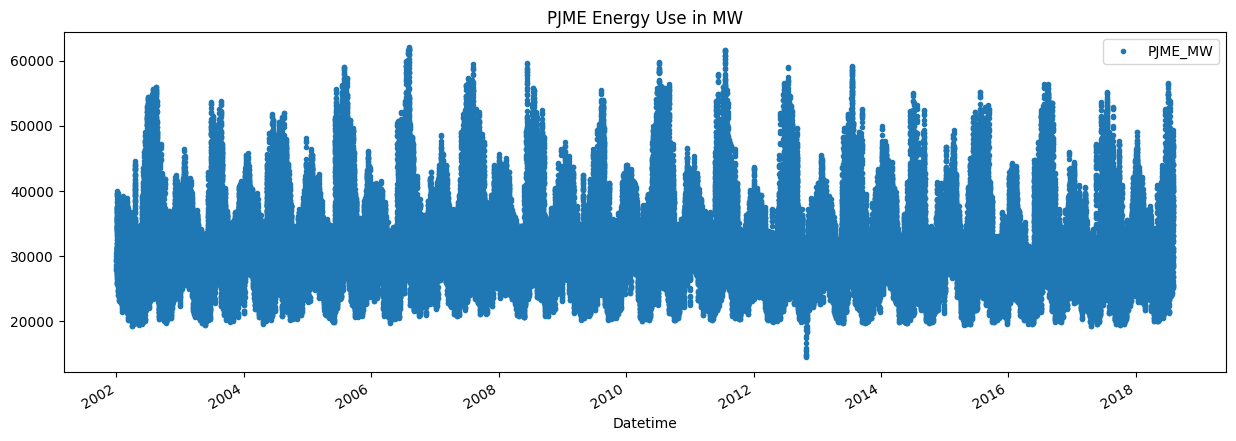

In [ ]:
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='PJME Energy Use in MW')
plt.show()

Que observamos en la gráfica?

**Valores faltantes:**

In [ ]:
print('Cantidad de NaNs:')
for column in df:
    nans = df[column].isna().sum()
    print(f'\tColumna {column}: {nans}')

Cantidad de NaNs:
	Columna PJME_MW: 0


In [ ]:
df.tail()

,PJME_MW
Datetime,
2018-08-02 20:00:00,44057.0
2018-08-02 21:00:00,43256.0
2018-08-02 22:00:00,41552.0
2018-08-02 23:00:00,38500.0
2018-08-03 00:00:00,35486.0


**Análisis de Outliers**

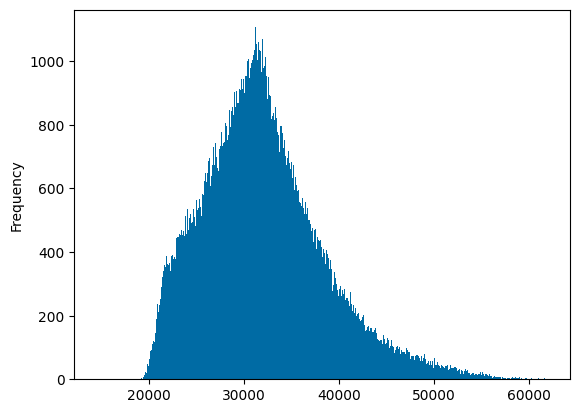

In [ ]:
df['PJME_MW'].plot(kind='hist', bins=500);

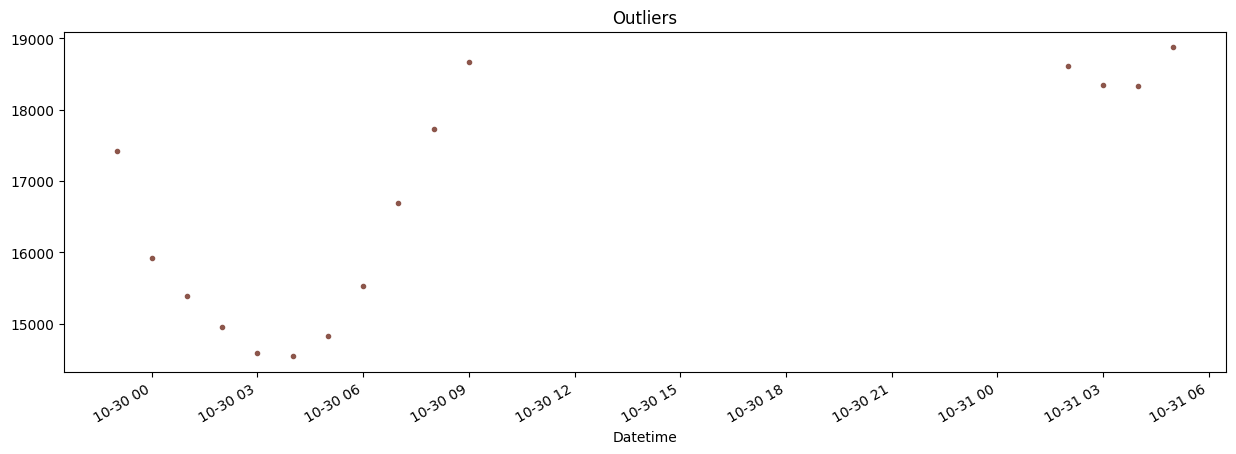

In [ ]:
df.query('PJME_MW < 19_000')['PJME_MW'].plot(style='.',figsize=(15, 5), color=color_pal[5],title='Outliers');

In [ ]:
#df = df.query('PJME_MW > 19_000').copy()

Se genera un array de números aleatorios uniformemente distribuidos entre 19000 y 20000.

In [ ]:
condicion = df['PJME_MW'] < 19000
df.loc[condicion, 'PJME_MW'] = np.random.uniform(19000, 20000, condicion.sum())

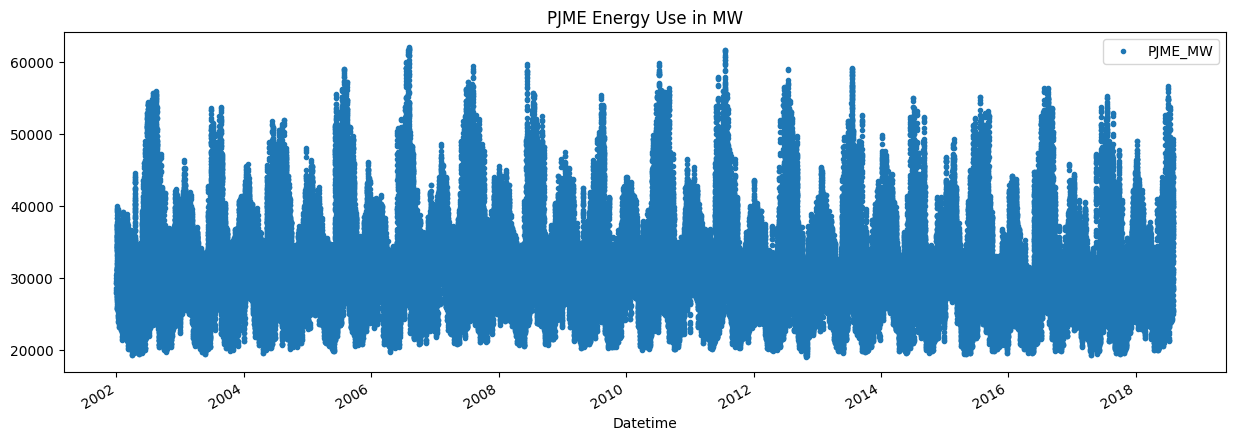

In [ ]:
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='PJME Energy Use in MW')
plt.show()

**Separación del dataset en train, test**

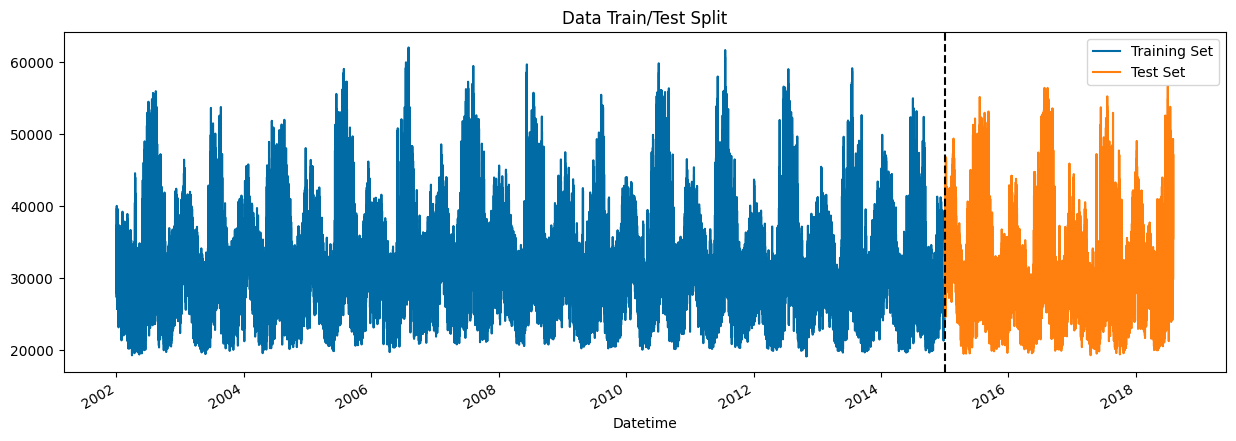

In [ ]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

**Cross Validation para Series de Tiempo**

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html

La siguiente línea de código crea un objeto de tipo TimeSeriesSplit que se utiliza para dividir una serie temporal en conjuntos de entrenamiento y prueba para su validación cruzada.

n_splits=5: Indica que se dividirá la serie temporal en 5 conjuntos diferentes  

Gap: se asegura que el conjunto de prueba refleje mejor una situación en la que solo se tiene información hasta un cierto punto en el tiempo, y el modelo debe hacer predicciones futuras basadas en ese conocimiento limitado.

In [ ]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24) #se están dejando 24 hrs como brecha entre el conjunto de entrenamiento y el conjunto de prueba. (mayor representatividad)
df = df.sort_index()

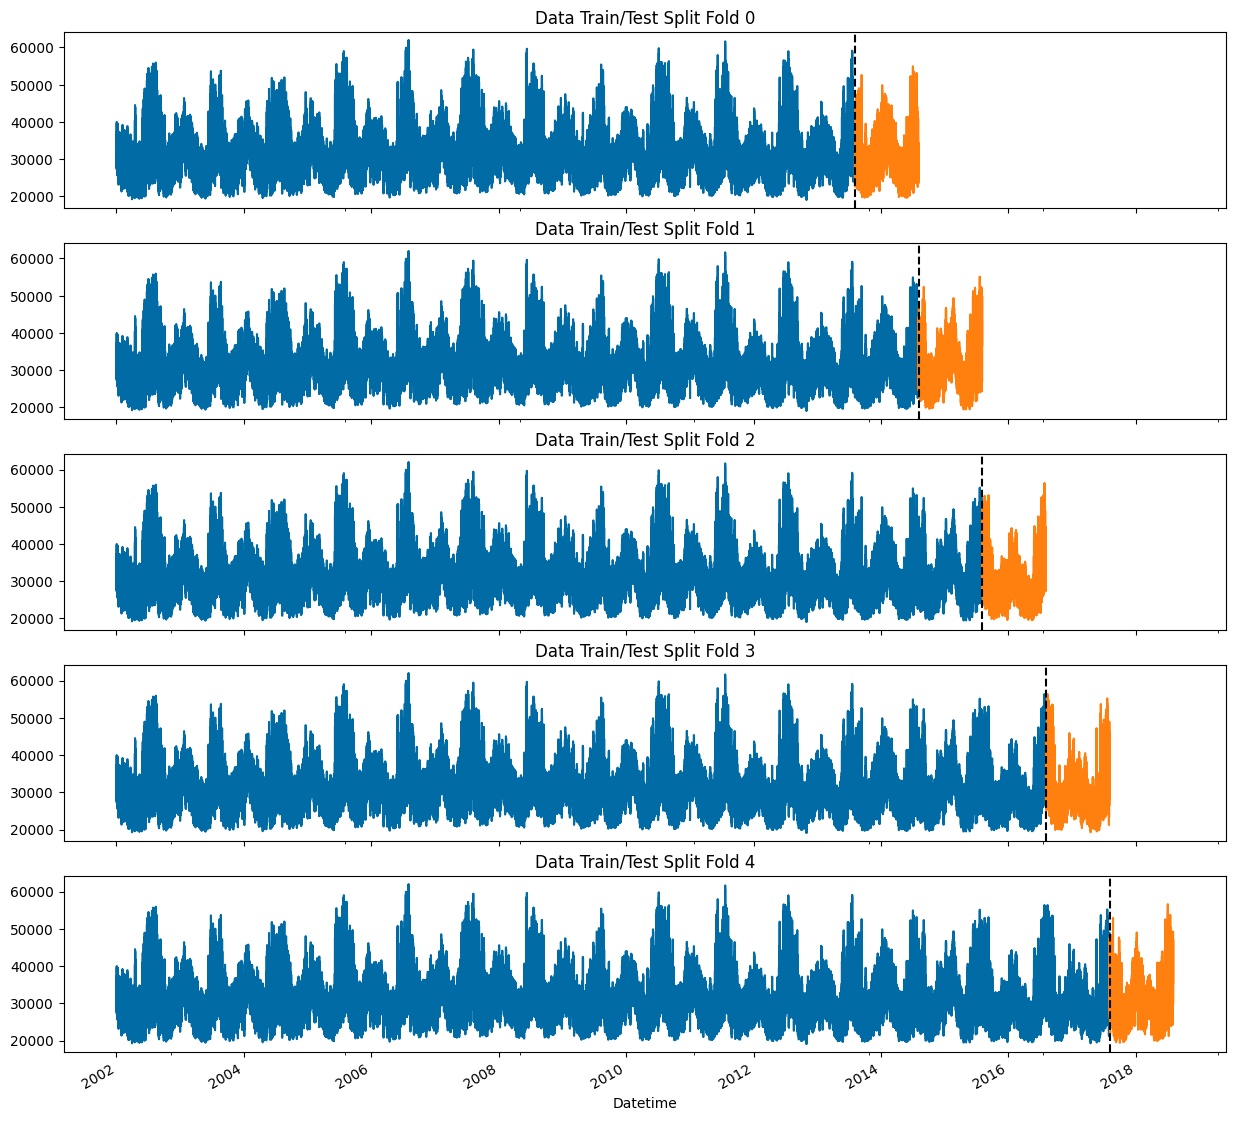

In [ ]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    val = df.iloc[val_idx]
    train['PJME_MW'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    val['PJME_MW'].plot(ax=axs[fold],label='Val Set')
    axs[fold].axvline(val.index.min(), color='black', ls='--')
    fold += 1
plt.show()

Visualizamos la estructura de tss

In [ ]:
tss

TimeSeriesSplit(gap=24, max_train_size=None, n_splits=5, test_size=8760)

In [ ]:
for i, (train_index, test_index) in enumerate(tss.split(df)):
     print(f"Fold {i}:")
     print(f"  Train: index={train_index}")
     print(f"  Test:  index={test_index}")

Fold 0:
  Train: index=[     0      1      2 ... 101539 101540 101541]
  Test:  index=[101566 101567 101568 ... 110323 110324 110325]
Fold 1:
  Train: index=[     0      1      2 ... 110299 110300 110301]
  Test:  index=[110326 110327 110328 ... 119083 119084 119085]
Fold 2:
  Train: index=[     0      1      2 ... 119059 119060 119061]
  Test:  index=[119086 119087 119088 ... 127843 127844 127845]
Fold 3:
  Train: index=[     0      1      2 ... 127819 127820 127821]
  Test:  index=[127846 127847 127848 ... 136603 136604 136605]
Fold 4:
  Train: index=[     0      1      2 ... 136579 136580 136581]
  Test:  index=[136606 136607 136608 ... 145363 145364 145365]


**Feature Engineering**

In [ ]:
def create_features(df):
    """
    Creamos features basadas en el índice tiempo.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

In [ ]:
df = create_features(df)

Agregamos rezagos de la variable target:

In [ ]:
def add_lags(df):
    target_map = df['PJME_MW'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [ ]:
df = add_lags(df)

In [ ]:
df.head(3)

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3
Datetime,,,,,,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,1,1,NaN,NaN,NaN
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,1,1,NaN,NaN,NaN
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,1,1,NaN,NaN,NaN


Verificaciones:

In [ ]:
# List of specific dates to filter
specific_dates = ['2002-12-30 23:00:00' ,'2003-12-30 23:00:00','2004-12-31 00:00:00','2005-01-01 00:00:00','2005-01-01 01:00:00']

# Convert the list of specific dates to a DatetimeIndex
specific_dates_index = pd.to_datetime(specific_dates)

# Filter the DataFrame using the isin method
filtered_df = df[df.index.isin(specific_dates_index)]

filtered_df

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3
Datetime,,,,,,,,,,,,
2002-12-30 23:00:00,31619.0,23,0,4,12,2002,364,30,1,NaN,NaN,NaN
2003-12-30 23:00:00,32228.0,23,1,4,12,2003,364,30,1,28483.0,31857.0,NaN
2004-12-31 00:00:00,29407.0,0,4,4,12,2004,366,31,53,27446.0,30228.0,31038.0
2005-01-01 00:00:00,27384.0,0,5,1,1,2005,1,1,53,27539.0,30533.0,30924.0
2005-01-01 01:00:00,25978.0,1,5,1,1,2005,1,1,53,25496.0,28493.0,28635.0


In [ ]:
target_index = '2004-12-31 00:00:00'
lag_value1 = df.loc[target_index, 'lag1']
lag_value2 = df.loc[target_index, 'lag2']
lag_value3 = df.loc[target_index, 'lag3']

print(f"El valor correspondiente al índice {target_index} y el lag de 364 días es: {lag_value1}")
print(f"El valor correspondiente al índice {target_index} y el lag de 728 días es: {lag_value2}")
print(f"El valor correspondiente al índice {target_index} y el lag de 1092 días es: {lag_value3}")

El valor correspondiente al índice 2004-12-31 00:00:00 y el lag de 364 días es: 27446.0
El valor correspondiente al índice 2004-12-31 00:00:00 y el lag de 728 días es: 30228.0
El valor correspondiente al índice 2004-12-31 00:00:00 y el lag de 1092 días es: 31038.0


In [ ]:
# Para obtener el índice de fila correspondiente al índice '2002-12-31 01:00:00' y el lag de 364 días
target_index = '2004-12-31 00:00:00'
lag_days1 = 364
lag_days2 = 728
lag_days3 = 1092

# Convierte el índice objetivo a un objeto Timestamp
target_index_dt = pd.to_datetime(target_index)

# Calcula el índice de fila utilizando iloc y la diferencia en días
target_row_index1 = df.index.get_loc(target_index_dt - pd.Timedelta(days=lag_days1))
target_row_index2 = df.index.get_loc(target_index_dt - pd.Timedelta(days=lag_days2))
target_row_index3 = df.index.get_loc(target_index_dt - pd.Timedelta(days=lag_days3))

print(f"El índice de fila correspondiente al índice {target_index} y el lag de {lag_days1} días es: {target_row_index1}")
print(f"El índice de fila correspondiente al índice {target_index} y el lag de {lag_days2} días es: {target_row_index2}")
print(f"El índice de fila correspondiente al índice {target_index} y el lag de {lag_days3} días es: {target_row_index3}")

El índice de fila correspondiente al índice 2004-12-31 00:00:00 y el lag de 364 días es: 17539
El índice de fila correspondiente al índice 2004-12-31 00:00:00 y el lag de 728 días es: 8805
El índice de fila correspondiente al índice 2004-12-31 00:00:00 y el lag de 1092 días es: 71


In [ ]:
# Lista de índices iloc a filtrar
indices_iloc = [17539,8805,71]

# Filtrar el DataFrame original solo en la columna 'PJME_MW' para los índices iloc
filtered_column = df['PJME_MW'].iloc[indices_iloc]

# Mostrar el resultado
filtered_column

Datetime
2004-01-02    27446.0
2003-01-03    30228.0
2002-01-04    31038.0
Name: PJME_MW, dtype: float64

Simplemente corroboramos con los índices el dataframe original que los lags elaborados corrspondan respectivamente a 1, 2 y 3 años.

**Entrenamiento**

In [ ]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()

In [ ]:
fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    val = df.iloc[val_idx]

    #train = create_features(train)
    #val = create_features(val)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3']
    TARGET = 'PJME_MW'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_val = val[FEATURES]
    y_val = val[TARGET]

    reg = xgb.XGBRegressor(booster='gbtree', #utilizar modelado basado en árboles
                           n_estimators=1000, #n_estimators – Número de árboles que llevan a cabo el boosting. También se entiende como el número de iteraciones de boosting.
                           objective='reg:linear', #Aquí es donde se indica si queremos hacer regresión
                           max_depth=3, #Máxima profundidad de un arbol.
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],
            eval_metric=['rmse', 'mae'],
            verbose=100)

    y_pred = reg.predict(X_val)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_val, y_pred))
    scores.append(score)

[0]	validation_0-rmse:6458.54633	validation_0-mae:4965.27154	validation_1-rmse:6142.83699	validation_1-mae:4949.45294


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [19:45:19] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:4368.64111	validation_0-mae:3287.06528	validation_1-rmse:4103.53148	validation_1-mae:3337.24125
[200]	validation_0-rmse:3812.85609	validation_0-mae:2843.25613	validation_1-rmse:3762.82310	validation_1-mae:2979.62643
[300]	validation_0-rmse:3538.67045	validation_0-mae:2628.79608	validation_1-rmse:3716.21317	validation_1-mae:2863.89178
[400]	validation_0-rmse:3387.52033	validation_0-mae:2504.64732	validation_1-rmse:3747.01691	validation_1-mae:2844.64241
[500]	validation_0-rmse:3311.24330	validation_0-mae:2442.78395	validation_1-rmse:3769.61771	validation_1-mae:2840.64266
[600]	validation_0-rmse:3261.11745	validation_0-mae:2404.26562	validation_1-rmse:3788.77866	validation_1-mae:2844.56192
[700]	validation_0-rmse:3222.32396	validation_0-mae:2377.06098	validation_1-rmse:3792.94760	validation_1-mae:2843.74962
[800]	validation_0-rmse:3188.41931	validation_0-mae:2351.04412	validation_1-rmse:3797.29957	validation_1-mae:2841.68269
[900]	validation_0-rmse:3158.61619	valid

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [19:45:34] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:4372.40355	validation_0-mae:3297.76136	validation_1-rmse:4160.36813	validation_1-mae:3341.83523
[200]	validation_0-rmse:3835.11267	validation_0-mae:2862.53887	validation_1-rmse:3701.55075	validation_1-mae:2878.40925
[300]	validation_0-rmse:3573.69914	validation_0-mae:2656.09365	validation_1-rmse:3558.87601	validation_1-mae:2712.58003
[400]	validation_0-rmse:3430.36638	validation_0-mae:2537.88900	validation_1-rmse:3514.28672	validation_1-mae:2644.86284
[500]	validation_0-rmse:3347.52414	validation_0-mae:2472.62767	validation_1-rmse:3490.66245	validation_1-mae:2597.75314
[600]	validation_0-rmse:3298.33041	validation_0-mae:2436.63433	validation_1-rmse:3471.58252	validation_1-mae:2564.33440
[700]	validation_0-rmse:3258.55620	validation_0-mae:2406.10345	validation_1-rmse:3451.79181	validation_1-mae:2536.18743
[800]	validation_0-rmse:3221.15278	validation_0-mae:2377.64833	validation_1-rmse:3429.03420	validation_1-mae:2492.69212
[900]	validation_0-rmse:3194.35963	valid

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [19:45:50] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:4367.64583	validation_0-mae:3302.82017	validation_1-rmse:4472.24547	validation_1-mae:3685.02076
[200]	validation_0-rmse:3834.10574	validation_0-mae:2863.49929	validation_1-rmse:3916.45928	validation_1-mae:3183.05075
[300]	validation_0-rmse:3592.27821	validation_0-mae:2669.37848	validation_1-rmse:3704.45763	validation_1-mae:2972.78739
[400]	validation_0-rmse:3449.78248	validation_0-mae:2551.86477	validation_1-rmse:3623.68272	validation_1-mae:2881.14781
[500]	validation_0-rmse:3375.38141	validation_0-mae:2491.92420	validation_1-rmse:3601.11446	validation_1-mae:2854.42812
[600]	validation_0-rmse:3321.25502	validation_0-mae:2451.33978	validation_1-rmse:3615.56238	validation_1-mae:2861.41274
[700]	validation_0-rmse:3279.37321	validation_0-mae:2420.51256	validation_1-rmse:3637.91637	validation_1-mae:2885.35609
[800]	validation_0-rmse:3245.25746	validation_0-mae:2394.05032	validation_1-rmse:3672.79727	validation_1-mae:2931.32212
[900]	validation_0-rmse:3219.89345	valid

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [19:46:09] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:4366.93347	validation_0-mae:3308.07742	validation_1-rmse:4642.39763	validation_1-mae:3665.32583
[200]	validation_0-rmse:3828.84001	validation_0-mae:2863.68913	validation_1-rmse:4278.00435	validation_1-mae:3290.10404
[300]	validation_0-rmse:3589.82725	validation_0-mae:2669.65407	validation_1-rmse:4180.70935	validation_1-mae:3154.13254
[400]	validation_0-rmse:3450.69761	validation_0-mae:2556.67707	validation_1-rmse:4133.87794	validation_1-mae:3062.06934
[500]	validation_0-rmse:3376.88919	validation_0-mae:2497.51851	validation_1-rmse:4097.27383	validation_1-mae:2983.03465
[600]	validation_0-rmse:3323.43387	validation_0-mae:2458.18462	validation_1-rmse:4099.55141	validation_1-mae:2963.27848
[700]	validation_0-rmse:3282.35000	validation_0-mae:2426.26135	validation_1-rmse:4088.88519	validation_1-mae:2944.72422
[800]	validation_0-rmse:3250.66316	validation_0-mae:2402.00204	validation_1-rmse:4086.96413	validation_1-mae:2934.54992
[900]	validation_0-rmse:3223.73067	valid

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [19:46:27] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:4388.88275	validation_0-mae:3328.58812	validation_1-rmse:4184.27172	validation_1-mae:3267.92849
[200]	validation_0-rmse:3860.54098	validation_0-mae:2891.66126	validation_1-rmse:3875.28035	validation_1-mae:2929.10942
[300]	validation_0-rmse:3629.01333	validation_0-mae:2700.67300	validation_1-rmse:3881.76321	validation_1-mae:2885.66033
[400]	validation_0-rmse:3495.63776	validation_0-mae:2591.13216	validation_1-rmse:3948.18312	validation_1-mae:2903.06745
[500]	validation_0-rmse:3423.64769	validation_0-mae:2529.39483	validation_1-rmse:4008.50567	validation_1-mae:2933.06761
[600]	validation_0-rmse:3374.66263	validation_0-mae:2491.23085	validation_1-rmse:4049.15632	validation_1-mae:2964.18301
[700]	validation_0-rmse:3338.05352	validation_0-mae:2463.14209	validation_1-rmse:4052.78355	validation_1-mae:2966.74703
[800]	validation_0-rmse:3308.60093	validation_0-mae:2440.10922	validation_1-rmse:4047.12277	validation_1-mae:2963.25284
[900]	validation_0-rmse:3279.27180	valid

In [ ]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 3801.2704
Fold scores:[3779.053015676983, 3415.7061723942343, 3734.9571393524793, 4052.880910186887, 4023.7545585824837]


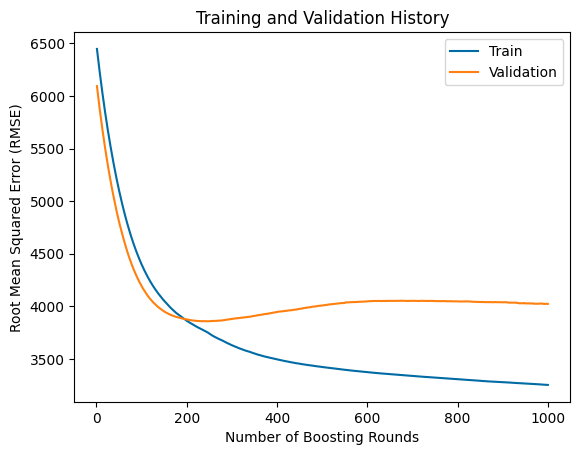

In [ ]:
# Plot the training and validation history
results = reg.evals_result()
train_error = results['validation_0']['rmse']
val_error = results['validation_1']['rmse']

epoch = range(1, len(train_error) + 1)

plt.plot(epoch, train_error, label='Train')
plt.plot(epoch, val_error, label='Validation')
plt.xlabel('Number of Boosting Rounds')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.title('Training and Validation History')
plt.legend()
plt.show()

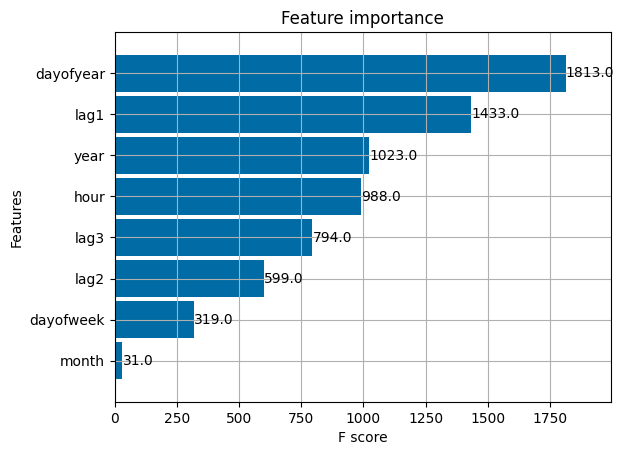

In [ ]:
_ = plot_importance(reg, height=0.9)

**Pronostico sobre los datos de Test**

In [ ]:
y_pred = reg.predict(X_val)

In [ ]:
y_pred

array([29242.277, 28211.305, 27445.945, ..., 39445.754, 36582.105,
       31692.797], dtype=float32)

Adicionamos la predicción al set de Validación

In [ ]:
val['prediction'] = reg.predict(X_val)

<ipython-input-107-98263895fe04>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['prediction'] = reg.predict(X_val)


In [ ]:
val['prediction']

Datetime
2017-08-03 01:00:00    29242.277344
2017-08-03 02:00:00    28211.304688
2017-08-03 03:00:00    27445.945312
2017-08-03 04:00:00    26755.298828
2017-08-03 05:00:00    26770.662109
                           ...     
2018-08-02 20:00:00    42505.699219
2018-08-02 21:00:00    41664.812500
2018-08-02 22:00:00    39445.753906
2018-08-02 23:00:00    36582.105469
2018-08-03 00:00:00    31692.796875
Name: prediction, Length: 8760, dtype: float32

In [ ]:
val

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3,prediction
Datetime,,,,,,,,,,,,,
2017-08-03 01:00:00,29189.0,1,3,3,8,2017,215,3,31,28809.0,29952.0,28465.0,29242.277344
2017-08-03 02:00:00,27584.0,2,3,3,8,2017,215,3,31,27039.0,27934.0,26712.0,28211.304688
2017-08-03 03:00:00,26544.0,3,3,3,8,2017,215,3,31,25881.0,26659.0,25547.0,27445.945312
2017-08-03 04:00:00,26012.0,4,3,3,8,2017,215,3,31,25300.0,25846.0,24825.0,26755.298828
2017-08-03 05:00:00,26187.0,5,3,3,8,2017,215,3,31,25412.0,25898.0,24927.0,26770.662109
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,2,31,42256.0,41485.0,38804.0,42505.699219
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,2,31,41210.0,40249.0,38748.0,41664.812500
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,2,31,39525.0,38698.0,37330.0,39445.753906


**Visualización de la predicción y los datos originales:**

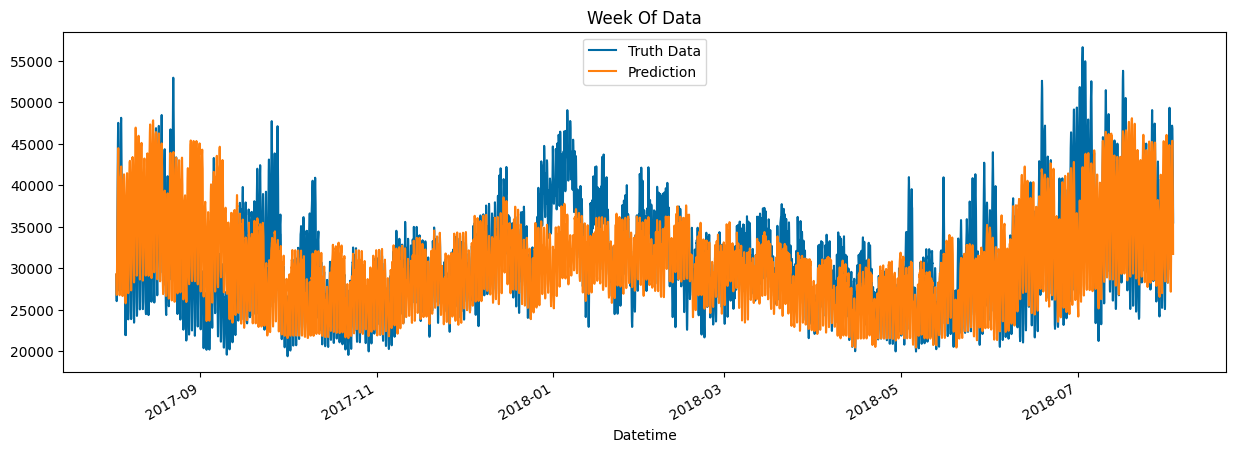

In [ ]:
ax = val.loc[(val.index >= '2017-08-03')]['PJME_MW'].plot(figsize=(15, 5), title='Week Of Data')
val.loc[(val.index >= '2017-08-03')]['prediction'].plot()
plt.legend(['Truth Data','Prediction'])
plt.show()

**Métricas de performance:**

In [ ]:
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

# Calculate error metrics using the filtered data
mse = mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
score = np.sqrt(mean_squared_error(y_val, y_pred))

In [ ]:
# Print the error metrics
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print(f'RMSE Score on Test set: {score:0.2f}')

Mean Squared Error (MSE): 16190600.747713318
Mean Absolute Error (MAE): 2951.751890250428
RMSE Score on Test set: 4023.75
